# Sleep stages classification
___

This notebooks aims to explore the dataset [sleep-edf](https://physionet.org/content/sleep-edfx/1.0.0/) de _physionet_. 

We ultimatly want to discriminate sleep stages from recorded EEG data. We can also use other signal which can be recorded from a cellphone.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import mne
from mne.datasets.sleep_physionet.age import fetch_data

## Data loading
____

Instead of downloading several times the dataset, we stock it once on our machine. We use the default path of mne, which is `~/mne_data/physionet-sleep-data`.

In [2]:
SUBJECTS = range(20)
NIGHT_RECORDINGS = [1, 2]

subject_files = fetch_data(subjects=SUBJECTS, recording=NIGHT_RECORDINGS);

Using default location ~/mne_data for PHYSIONET_SLEEP...


We also retrieve each patient information. We associate the same index as they are indexed within `subject_files`. Since we only have access to the first 20 patients data through MNE, we will discard patients information with an ID outside of that range.

When checking the `raw_data.info`, we can see that we have the property `raw_data.info["meas_date"]`, which represents the start date and time of the recording. We can then mark the moment of the signal where the lights were turned off.

In [3]:
df_subject_information = pd.read_csv("data/SC-subjects.csv", delimiter=';')

df_subject_information = df_subject_information.rename(columns={"sex (F=1)": "sex"}, errors="raise")
df_subject_information = df_subject_information[df_subject_information["subject"].isin(SUBJECTS)]

df_subject_information


,subject,night,age,sex,LightsOff
0,0,1,33,1,0:38
1,0,2,33,1,21:57
2,1,1,33,1,22:44
3,1,2,33,1,22:15
4,2,1,26,1,22:50
5,2,2,26,1,22:57
6,3,1,26,1,0:02
7,3,2,26,1,0:24
8,4,1,34,1,23:12
9,4,2,34,1,23:35


## Channel exploration
___

We will explore the different channels for one subject's night. We will not look at the rectal temperature channel since we will not be able to get one ourself.


In [4]:
raw_data = mne.io.read_raw_edf(subject_files[13][0], preload=True, verbose=False)

NUMBER_CHANNELS = raw_data.info["nchan"]
LOWPASS_FILTER = raw_data.info["lowpass"]
SAMPLING_FREQ = raw_data.info["sfreq"]

print(raw_data)
print("The corresponding file has %i channels, has a low pass filter of %i Hz and a sampling rate of %i Hz." % (NUMBER_CHANNELS, LOWPASS_FILTER, SAMPLING_FREQ))
print("The channels are ", raw_data.info["ch_names"])
print(f"The recording is {raw_data.n_times/(3600 * SAMPLING_FREQ)} hours long.")

mapping = {'EEG Fpz-Cz': 'eeg',
           'EEG Pz-Oz': 'eeg',
           'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_data.set_channel_types(mapping)
raw_data.drop_channels('Temp rectal')
raw_data.set_annotations(mne.read_annotations(subject_files[13][1]), emit_warning=False)


<RawEDF  |  SC4062E0-PSG.edf, n_channels x n_times : 7 x 8490000 (84900.0 sec), ~453.4 MB, data loaded>
The corresponding file has 7 channels, has a low pass filter of 50 Hz and a sampling rate of 100 Hz.
The channels are  ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
The recording is 23.583333333333332 hours long.


<RawEDF  |  SC4062E0-PSG.edf, n_channels x n_times : 6 x 8490000 (84900.0 sec), ~388.7 MB, data loaded>

Because we cannot look at all the night's recording for all channels, since they have too many data points to be displayed and causes an error, we will look at the same subwindow of data for all channels.

In [5]:
DURATION = 30000.0
START_WINDOW = 24000

### EEG Channel
___

Electrode placement for this dataset was choosen along the midline axis. We have a **bipolar electrode montage**, which means that you have two electrodes per one channel, so you have a reference electrode for each channel.

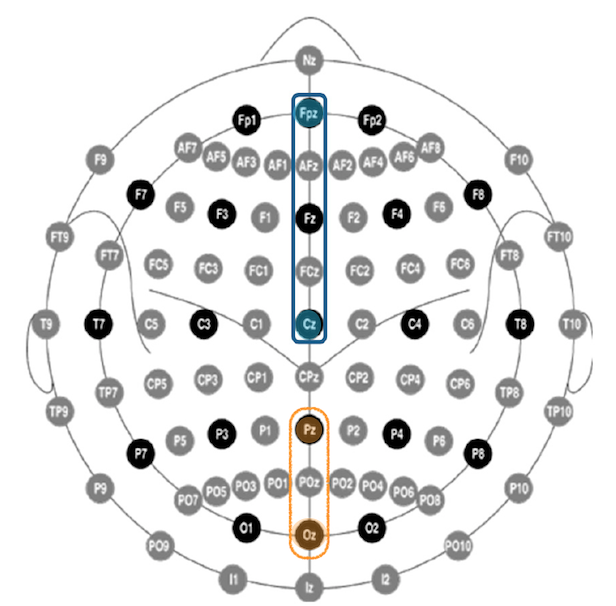

#### Fpz-Cz Channel
____

As its name states, it is an eeg signal with the electrode placed on the forehead and its reference placed on top of the head. Both are centered. They can be seen above in the blue rectangle.

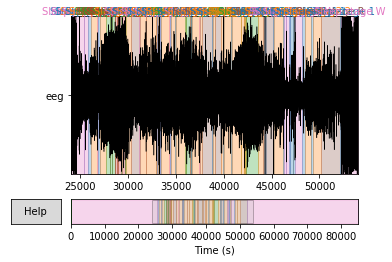

In [6]:
raw_data.copy().pick('EEG Fpz-Cz').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

#### Pz-Oz Channel
____

We can see the electrodes located at the back of the head follow the same pattern as with the other channel. The electrode montage for this channel is represented in orange in the figure above. 

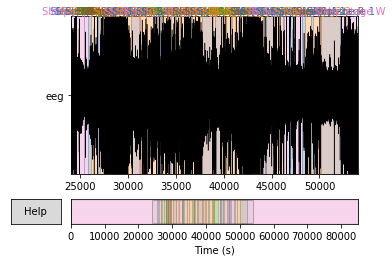

In [7]:
raw_data.copy().pick('EEG Pz-Oz').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

We can then compare the PSD plot from both channels. We can see the general amplitude of the **EEG Fpz-Cz** channel is greater than the amplitude of the **EEG Pz-Oz** channel.

<ipython-input-8-5dbc023a3bd8>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_data.copy().pick(['EEG Fpz-Cz','EEG Pz-Oz']).plot_psd(tmin=START_WINDOW, tmax=START_WINDOW+DURATION);


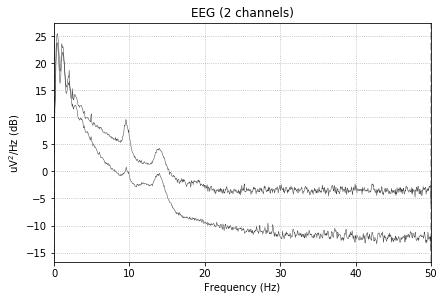

In [8]:
raw_data.copy().pick(['EEG Fpz-Cz','EEG Pz-Oz']).plot_psd(tmin=START_WINDOW, tmax=START_WINDOW+DURATION);


### EOG Channel
____

This channel is a horizontal EOG signal, with electrodes placed on both outer corners of the eyes, as you can see [here](https://www.researchgate.net/figure/Typical-EOG-electrode-placements-for-Horizontal-and-Vertical-channels_fig1_40452196).

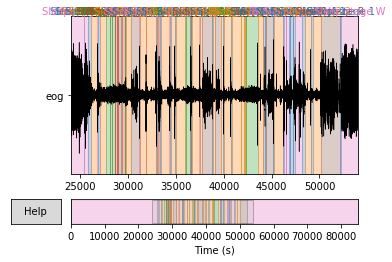

In [9]:
raw_data.copy().pick('EOG horizontal').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

#### Eye movemnent artifact on EEG Channels
____

As it is described in this [tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/plot_10_preprocessing_overview.html#ocular-artifacts-eog), we can detect epochs that contain artefact of eye movement by looking at the EOG signal.

The result of the below operations center all epochs of the EEG channels around the eye movement artefact.

In [10]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw_data)


EOG channel index for this subject is: [2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 2.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 45.25 Hz)
- Filter length: 1024 samples (10.240 sec)

Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition ba

No picks and no groupby, showing the first five channels ...
27641 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


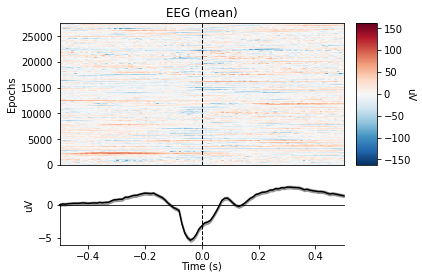

[<Figure size 432x288 with 3 Axes>]

In [11]:
eog_epochs.plot_image(combine='mean')


### Chin EMG Channel
____

We finally also have a EMG channel to detect muscle movement near the mouth. We can see the electrodes are sort of placed as below:

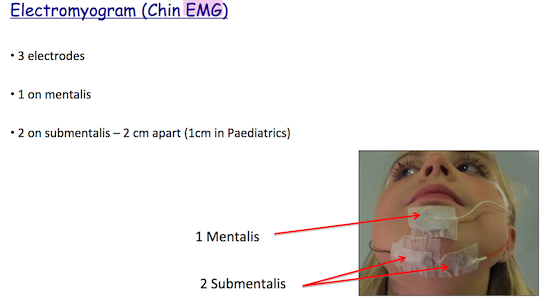

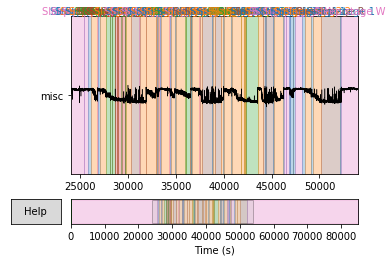

In [12]:
raw_data.copy().pick('EMG submental').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

### Event marker
____

It has a sampling rate of 1hz. This channel doesn't have a proper description, so we cannot interpret its meaning. We therefore ignore it.

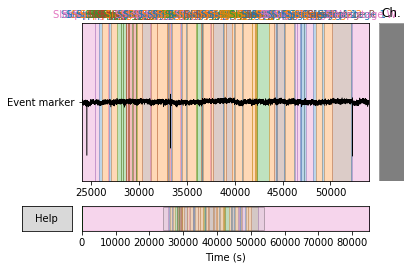

Converting "time" to "<class 'numpy.int64'>"...


<RawEDF  |  SC4062E0-PSG.edf, n_channels x n_times : 5 x 8490000 (84900.0 sec), ~323.9 MB, data loaded>

In [13]:
raw_data.copy().pick('Event marker').plot(duration=DURATION, start=START_WINDOW);
raw_data.to_data_frame(picks='Event marker').head()

raw_data.drop_channels(['Event marker'])

# Preprocessing

We're using an arbitrary 30 seconds window to create our epochs. Also, we're merging the stage 3 and stage 4 into a stage 3/4, because it is the  American Academy of Sleep Medicine official standard since 2007.

In [14]:
EPOCH_DURATION = 30. # in seconds

ANNOTATIONS_EVENT_ID = {
  'Sleep stage W': 1,
  'Sleep stage 1': 2,
  'Sleep stage 2': 3,
  'Sleep stage 3': 4,
  'Sleep stage 4': 4,
  'Sleep stage R': 5
}

EVENT_ID = {
  'Sleep stage W': 1,
  'Sleep stage 1': 2,
  'Sleep stage 2': 3,
  'Sleep stage 3/4': 4,
  'Sleep stage R': 5
}

MAX_TIME = EPOCH_DURATION - 1. / SAMPLING_FREQ  # tmax in included

In [15]:
### Comment the following code if you already saved the epochs into a .fif file.

# all_subject_epochs = []

# for i in range(39):
#     print(f"Retrieving file no.{i}")
#     # 1. get all epochs of one person
#     raw_data = mne.io.read_raw_edf(subject_files[i][0], preload=True, verbose=False, exclude=["Temp rectal", "Event marker", "Resp oro-nasal", "EMG submental", "EOG horizontal"])

#     # 2. add the sleep stage annotation to the raw data
#     raw_data.set_annotations(mne.read_annotations(subject_files[i][1]), emit_warning=False)

#     # 3. transform into epochs
#     events, _ = mne.events_from_annotations(raw_data, event_id=ANNOTATIONS_EVENT_ID, chunk_duration=EPOCH_DURATION, verbose=False)
#     df = pd.DataFrame()
#     df = df.append([df_subject_information.loc[[i]]] * len(events))
#     epochs = mne.Epochs(raw=raw_data, events=events, event_id=EVENT_ID, tmin=0., tmax=MAX_TIME, baseline=None, verbose=False, metadata=df)
#     epochs.equalize_event_counts(EVENT_ID.keys())
#     all_subject_epochs.append(epochs)

# print("Concatenating all epochs together...")
# epochs = mne.concatenate_epochs(all_subject_epochs)

In [16]:
# epochs.save("data/data-epo.fif")

In [17]:
epochs = mne.read_epochs("data/data-epo.fif")

Reading data/data-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   29990.00 ms
        0 CTF compensation matrices available
11640 matching events found
No baseline correction applied
Adding metadata with 5 columns
0 projection items activated


In [18]:
epochs 

<EpochsFIF  |   11640 events (all good), 0 - 29.99 sec, baseline off, ~532.8 MB, data loaded, with metadata,
 'Sleep stage 1': 2328
 'Sleep stage 2': 2328
 'Sleep stage 3/4': 2328
 'Sleep stage R': 2328
 'Sleep stage W': 2328>

## Analyzing PSD of epochs grouped by sleep stage score
____

We want to check if power band amplitudes change depending on the epoch's sleep stage class. We will then take all epochs with the same classification and then display their respective PSD.

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


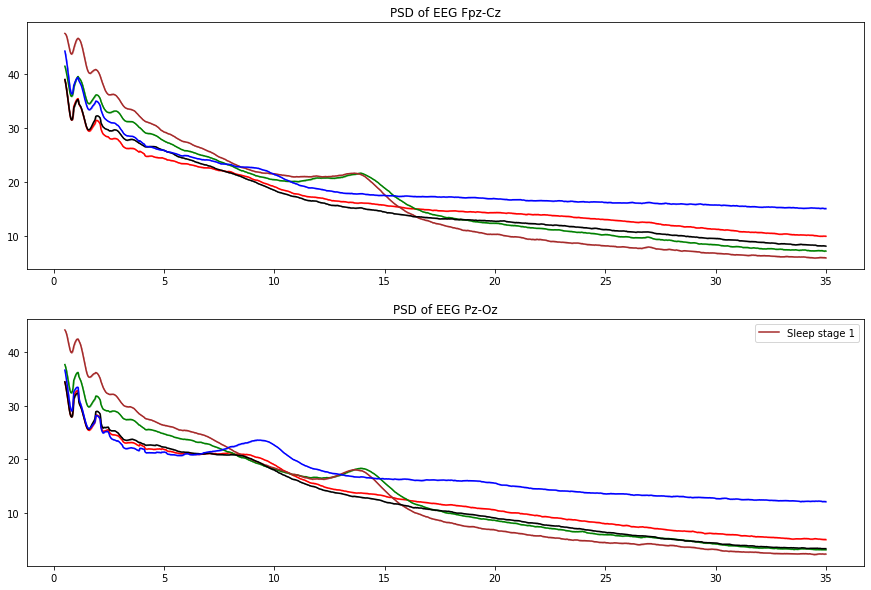

In [19]:
EEG_CHANNELS = ['EEG Fpz-Cz','EEG Pz-Oz']
fig, axes = plt.subplots(ncols=1, nrows=len(EEG_CHANNELS), figsize=(15, 10))

colors = ['red', 'green', 'brown', 'black', 'blue']
event_id_sorted = sorted(EVENT_ID.keys())

for ax, channel_name in zip(axes, EEG_CHANNELS):
    for stage, color in zip(event_id_sorted, colors):
        epochs[stage].plot_psd(n_jobs=-1, ax=ax, show=False, color=color, picks=channel_name, fmax=35, fmin=0.5)
    ax.set_title(f"PSD of {channel_name}")

axes[-1].legend(axes[-1].lines[2::3], event_id_sorted)
plt.show()

In [20]:
epochs_df = epochs.to_data_frame(long_format=True, picks="eeg")
epochs_df.drop(columns='ch_type')

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


,condition,epoch,time,channel,observation
0,Sleep stage W,0,0.0,EEG Fpz-Cz,10.830769
1,Sleep stage W,0,0.0,EEG Pz-Oz,-3.043224
2,Sleep stage W,0,10.0,EEG Fpz-Cz,2.297436
3,Sleep stage W,0,10.0,EEG Pz-Oz,0.603663
4,Sleep stage W,0,20.0,EEG Fpz-Cz,7.736264
...,...,...,...,...,...
69839995,Sleep stage R,11639,29970.0,EEG Pz-Oz,5.821001
69839996,Sleep stage R,11639,29980.0,EEG Fpz-Cz,-11.435898
69839997,Sleep stage R,11639,29980.0,EEG Pz-Oz,6.494505
69839998,Sleep stage R,11639,29990.0,EEG Fpz-Cz,-11.338462


In [21]:
epochs_df.head()


,condition,epoch,time,channel,observation,ch_type
0,Sleep stage W,0,0.0,EEG Fpz-Cz,10.830769,eeg
1,Sleep stage W,0,0.0,EEG Pz-Oz,-3.043224,eeg
2,Sleep stage W,0,10.0,EEG Fpz-Cz,2.297436,eeg
3,Sleep stage W,0,10.0,EEG Pz-Oz,0.603663,eeg
4,Sleep stage W,0,20.0,EEG Fpz-Cz,7.736264,eeg


In [22]:
epoch_events = epochs_df[['epoch', 'condition']].drop_duplicates(keep="first").set_index('epoch')['condition'].to_numpy()
epoch_events

array(['Sleep stage W', 'Sleep stage W', 'Sleep stage W', ...,
       'Sleep stage W', 'Sleep stage 1', 'Sleep stage R'], dtype=object)

In [23]:
del epochs_df

In [24]:
# psds will be of shape (n_epochs, n_channels, n_freqs) i.e. 8281 epochs x 2 channel x 75 freq

psds, freqs = mne.time_frequency.psd_welch(epochs, picks=EEG_CHANNELS, fmin=0.5, fmax=30.)

scaling = 1e6 # see here for default eeg scaling using for plotting (i.e. plot_psd): https://github.com/mne-tools/mne-python/blob/c437ed0bbcef3b6bf3a8beab2221ab5bff47722f/mne/defaults.py#L20 
psds *= scaling * scaling
np.log10(np.maximum(psds, np.finfo(float).tiny), out=psds)
psds *= 10

Effective window size : 2.560 (s)


In [25]:
len(freqs)

75

In [26]:

'''
ce qu'on voudrait serait un dataframe avec les colonnes suivantes
(pareil à epochs_df, sauf dans domain frequency avec psd):

- sleep-stage: event_id
- epoch: no de l'epoch
- frequency: fréquence issu de `freqs` (similaire à `time`de epochs_df)
- channel: EEG Fpz-Cz ou EEG Pz-Oz
- psd: valeur issue de `psds`

'''
psds_df_dict = { "sleep-stage": [],  "epoch": [], "frequency": [], "channel": [], "psd": [] }
NO_FREQS = len(freqs)

for no_epoch in range(len(psds)):
    current_sleep_stage = epoch_events[no_epoch]

    for no_channel in range(len(EEG_CHANNELS)):
        current_channel = EEG_CHANNELS[no_channel]
        
        psds_df_dict["sleep-stage"].extend([current_sleep_stage] * NO_FREQS)
        psds_df_dict["epoch"].extend([no_epoch] * NO_FREQS)
        psds_df_dict["channel"].extend([current_channel] * NO_FREQS)

        psds_df_dict["frequency"].extend(freqs)
        psds_df_dict["psd"].extend(psds[no_epoch][no_channel])


In [27]:
epoch_psds_df = pd.DataFrame(psds_df_dict)
epoch_psds_df

,sleep-stage,epoch,frequency,channel,psd
0,Sleep stage W,0,0.781250,EEG Fpz-Cz,21.727020
1,Sleep stage W,0,1.171875,EEG Fpz-Cz,19.709751
2,Sleep stage W,0,1.562500,EEG Fpz-Cz,18.327732
3,Sleep stage W,0,1.953125,EEG Fpz-Cz,16.589869
4,Sleep stage W,0,2.343750,EEG Fpz-Cz,15.045609
...,...,...,...,...,...
1745995,Sleep stage R,11639,28.125000,EEG Pz-Oz,-13.264014
1745996,Sleep stage R,11639,28.515625,EEG Pz-Oz,-13.289124
1745997,Sleep stage R,11639,28.906250,EEG Pz-Oz,-15.577900
1745998,Sleep stage R,11639,29.296875,EEG Pz-Oz,-15.849675


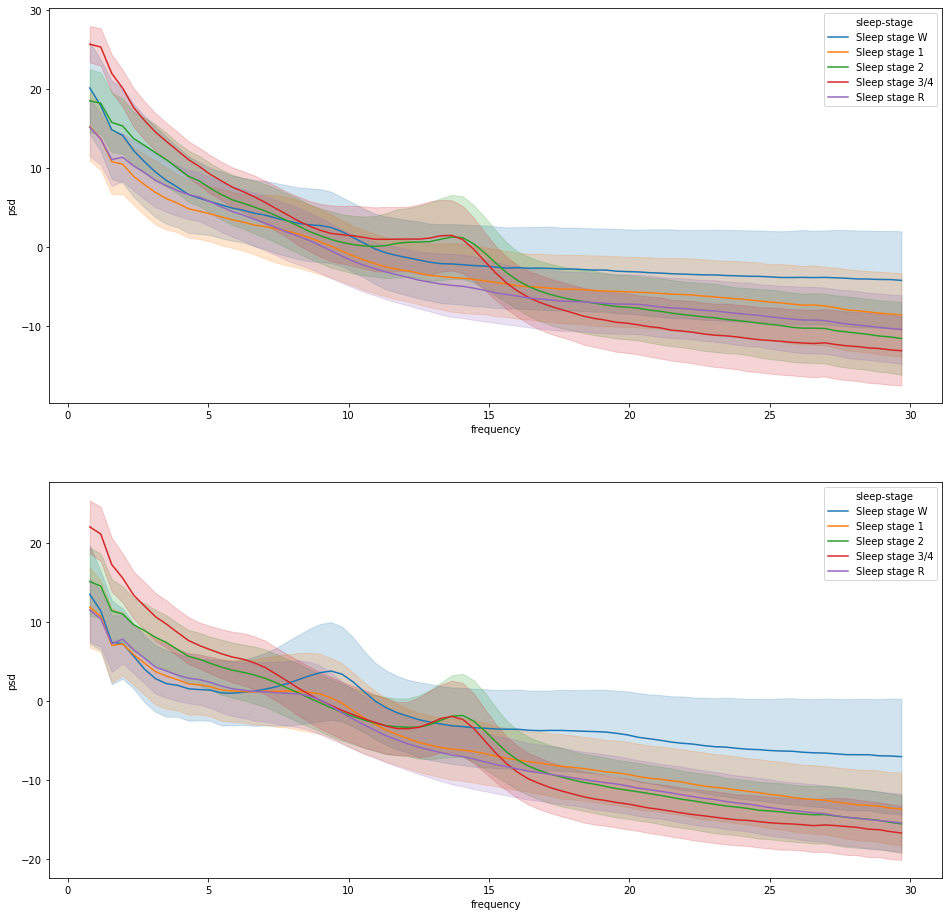

In [28]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 16))

sns.lineplot(x="frequency", y="psd", data=epoch_psds_df.query("channel == 'EEG Fpz-Cz'"), ci='sd', hue="sleep-stage", ax=ax[0])
sns.lineplot(x="frequency", y="psd", data=epoch_psds_df.query("channel == 'EEG Pz-Oz'"), ci="sd", hue="sleep-stage", ax=ax[1])


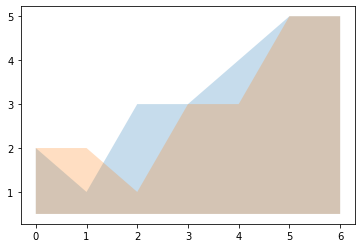

In [41]:
plt.fill_between(x=[0, 1, 2, 3, 4, 5, 6], y1=[2, 1, 3, 3, 4, 5, 5], y2=0.5, alpha=0.25)
plt.fill_between(x=[0, 1, 2, 3, 4, 5, 6], y1=[2, 2, 1, 3, 3, 5, 5], y2=0.5, alpha=0.25)